<h2>Portfolio Analysis – Usage</h2>

<p>This notebook provides a complete framework to build, analyze, and monitor an equity portfolio.</p>

<ul>
  <li><b>Risk/Return Comparison</b><br>
  A bar chart of <i>Return vs Volatility</i> highlights which stocks deliver the best balance between performance and risk.</li>

  <li><b>Drawdown Analysis</b><br>
  Focuses on the four stocks with the highest Sharpe ratios. The drawdown plot shows how much they lost during the worst periods, giving insight into downside risk.</li>

  <li><b>Correlation Matrix</b><br>
  Compares pairwise correlations across stocks. High and stable correlations (close to 1) suggest stocks move together – often the case within the same sector – raising the question of whether both should be held.</li>

  <li><b>Volatility vs Sharpe Ratio</b><br>
  The combined plot illustrates how portfolio quality evolves:
    <ul>
      <li>Rising volatility (blue) with falling Sharpe (orange) = deteriorating performance relative to risk.</li>
      <li>Falling volatility with rising Sharpe = favorable conditions.</li>
      <li>Peaks and troughs help identify different market regimes (stress vs calm) and guide potential rebalancing.</li>
    </ul>
  </li>

  <li><b>Portfolio Construction Rules</b><br>
  Initial capital (USD 1,000,000) is allocated across selected stocks:
    <ul>
      <li>No position may exceed <b>20% of capital</b> (USD 200,000).</li>
      <li>Target weights are normalized to sum to 100%.</li>
      <li>Fractional shares are not allowed; purchases use the most recent available price.</li>
      <li>Residual cash is tracked as <i>Leftover before</i>.</li>
      <li>A sweep function invests leftover cash by buying additional shares (if under the 20% cap). Any cash insufficient to buy even the cheapest stock is reported as <i>Leftover after</i>.</li>
    </ul>
  </li>

  <li><b>Efficient Frontier & Model Portfolios</b><br>
  The constructed portfolio is compared to benchmarks such as Equal-Weighted and other model portfolios. The efficient frontier illustrates the trade-off between expected return and risk.</li>

  <li><b>Monte Carlo Simulations</b><br>
  Based on historical returns, 5,000 random one-month paths are generated:
    <ul>
      <li>The <b>upper chart</b> shows the expected portfolio evolution.<br>
        – Central blue line = median scenario.<br>
        – Dark blue area = interquartile range (25–75%), i.e. most likely outcomes.<br>
        – Beige area = 5–95% confidence band, covering extreme but plausible cases.</li>
      <li>The <b>lower chart</b> shows the distribution of final one-month returns across all simulations.</li>
    </ul>
  </li>
</ul>

<p><b>In short:</b> the notebook helps you construct a portfolio under realistic constraints, evaluate its historical risk/return trade-offs, and project potential outcomes under different market conditions.</p>


In [1]:
pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [3]:
CAPITAL = 1_000_000
TICKERS = [
    "AAPL","MSFT","NVDA","GOOGL","AMZN",
    "META","AVGO","ADBE","AMD","COST",
    "LIN","UNH","JPM","V","NFLX"
]  # modifica libera (questi 15 li ho sparati a caso)
START, END = "1998-01-01", None
RF = 0.0
MAX_W = 0.20            # cap 20% per titolo (regola demmerda della gara)
N_SIMS = 5000           # scenari Monte Carlo per dopo
SEED = 10

plt.rcParams["figure.figsize"] = (9,5)

In [4]:
# Dati & Ritorni
import plotly.express as px

def load_prices(tickers, start, end):
    px = yf.download(tickers, start=start, end=end, progress=False)["Close"]
    if isinstance(px, pd.Series):
        px = px.to_frame()
    return px.ffill().dropna(how="any")

prices = load_prices(TICKERS, START, END)
ret = prices.pct_change().dropna()
rlog = np.log(prices/prices.shift(1)).dropna()

print(f"[DATA] rows={len(prices):,} | {prices.index.min().date()} → {prices.index.max().date()}")
print("[DATA] last prices:\n", prices.iloc[-1].round(2))

# Normalized Prices con Plotly (zoom)
normed = prices / prices.iloc[0]
fig = px.line(
    normed,
    x=normed.index,
    y=normed.columns,
    title="Normalized Prices (start=1.0)",
    labels={"value": "Normalized Price", "index": "Date", "variable": "Ticker"}
)
fig.update_layout(legend=dict(orientation="h", y=-0.2))
fig.show()

/tmp/ipython-input-3364868556.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  px = yf.download(tickers, start=start, end=end, progress=False)["Close"]


[DATA] rows=3,359 | 2012-05-18 → 2025-09-26
[DATA] last prices:
 Ticker
AAPL      255.46
ADBE      360.37
AMD       159.46
AMZN      219.78
AVGO      334.53
COST      915.95
GOOGL     246.54
JPM       316.06
LIN       474.41
META      743.75
MSFT      511.46
NFLX     1210.61
NVDA      178.19
UNH       344.08
V         337.37
Name: 2025-09-26 00:00:00, dtype: float64


        AnnReturn%  AnnVol%  Sharpe     MaxDD%
Ticker                                        
NVDA         62.47    45.40    1.38 -66.335094
AVGO         46.01    37.51    1.23 -48.299981
COST         22.60    20.55    1.10 -31.402439
MSFT         26.10    26.11    1.00 -37.148486
NFLX         43.33    46.41    0.93 -75.947318
V            21.34    23.76    0.90 -36.364897
GOOGL        23.43    27.55    0.85 -44.320040
JPM          21.61    26.09    0.83 -43.626514
AAPL         23.16    28.52    0.81 -43.797147
AMZN         25.47    32.21    0.79 -56.145263
LIN          14.12    21.31    0.66 -32.585030
META         25.01    39.84    0.63 -76.736092
ADBE         20.12    31.70    0.63 -60.021498
UNH          16.77    27.33    0.61 -61.390867
AMD          27.89    56.89    0.49 -74.922601


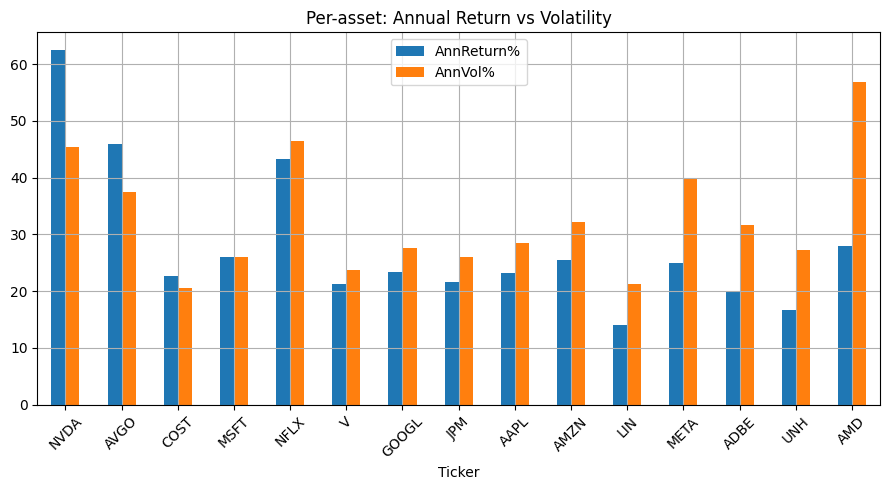

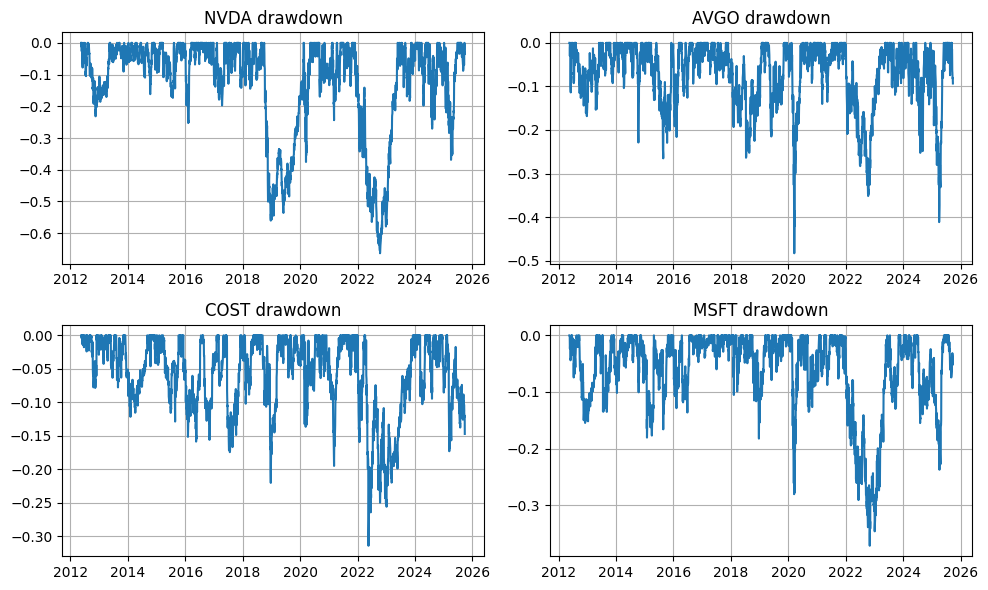

In [5]:
# Statistiche
def ann_return_log(rlog, periods=252):
    mu_d = rlog.mean()
    return np.exp(mu_d*periods) - 1.0

def ann_vol(ret, periods=252):
    return ret.std(ddof=1)*np.sqrt(periods)

def max_drawdown(price):
    cum = price/price.iloc[0]; peak = cum.cummax()
    return float((cum/peak - 1).min())

mu_ann  = ann_return_log(rlog)
vol_ann = ann_vol(ret)
shp_ind = (mu_ann - RF)/vol_ann.replace(0,np.nan)

stats = pd.DataFrame({
    "AnnReturn%": (mu_ann*100).round(2),
    "AnnVol%":    (vol_ann*100).round(2),
    "Sharpe":     shp_ind.round(2),
    "MaxDD%":     [max_drawdown(prices[c])*100 for c in prices.columns]
}).loc[TICKERS].sort_values("Sharpe", ascending=False)
print(stats)

# Return vs vol
stats[["AnnReturn%","AnnVol%"]].plot(kind="bar", rot=45, grid=True,
                                     title="Per-asset: Annual Return vs Volatility")
plt.tight_layout(); plt.show()

# drawdown per i 4 più grandi (per impatto da capire magari se evitare sberle visto il periodo che tutto al top)
top4 = list((prices.iloc[-1]*0+1).index[:4])
# uso 4 tickers con Sharpe migliore
top4 = list(stats.head(4).index)
fig, axes = plt.subplots(2,2, figsize=(10,6))
axes = axes.ravel()
for i,t in enumerate(top4):
    cum = prices[t]/prices[t].iloc[0]
    peak = cum.cummax()
    dd = cum/peak - 1
    axes[i].plot(dd.index, dd.values)
    axes[i].set_title(f"{t} drawdown")
    axes[i].grid(True)
plt.tight_layout(); plt.show()

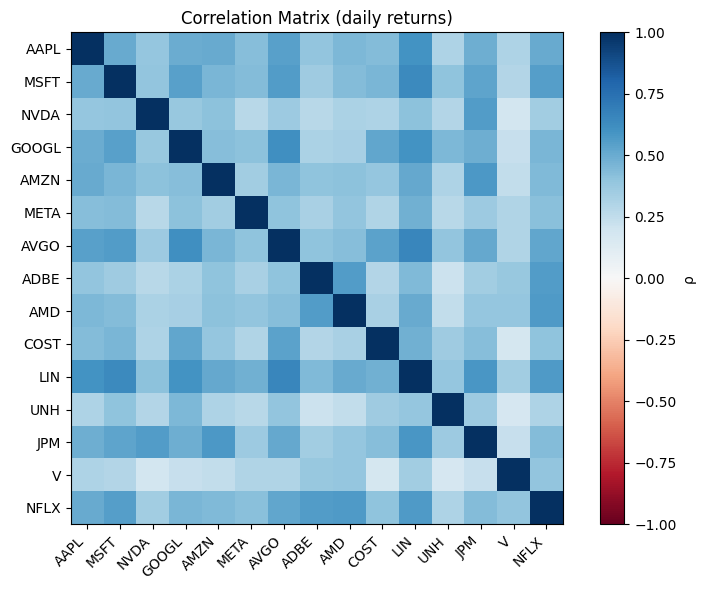

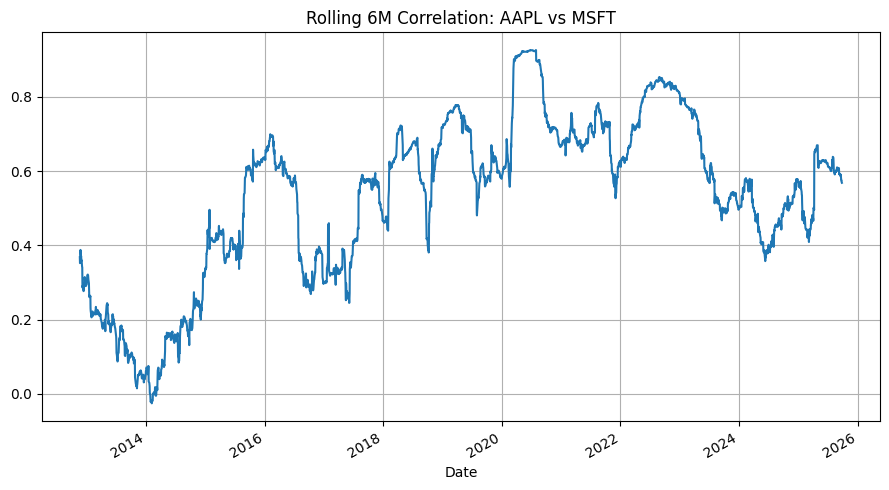

In [6]:
# Correlazioni
corr = ret.corr()
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(corr.values, cmap="RdBu", vmin=-1, vmax=1)
ax.set_xticks(range(len(TICKERS))); ax.set_xticklabels(TICKERS, rotation=45, ha='right')
ax.set_yticks(range(len(TICKERS))); ax.set_yticklabels(TICKERS)
plt.colorbar(im, ax=ax, label="ρ")
ax.set_title("Correlation Matrix (daily returns)")
plt.tight_layout(); plt.show()

# rolling correlation tra due nomi chiave (AAPL–MSFT come esempio, ma cambiare a piacimento)
a, b = "AAPL", "MSFT"
if a in TICKERS and b in TICKERS:
    rc = ret[a].rolling(126).corr(ret[b])
    rc.plot(title=f"Rolling 6M Correlation: {a} vs {b}", grid=True)
    plt.tight_layout(); plt.show()

[PORT EQ] ER=24.23%  Vol=21.91%  Sharpe=1.11


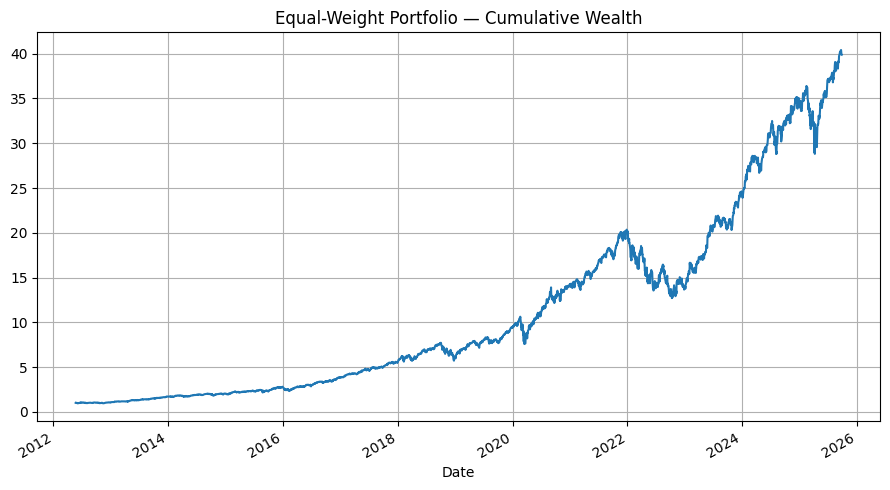

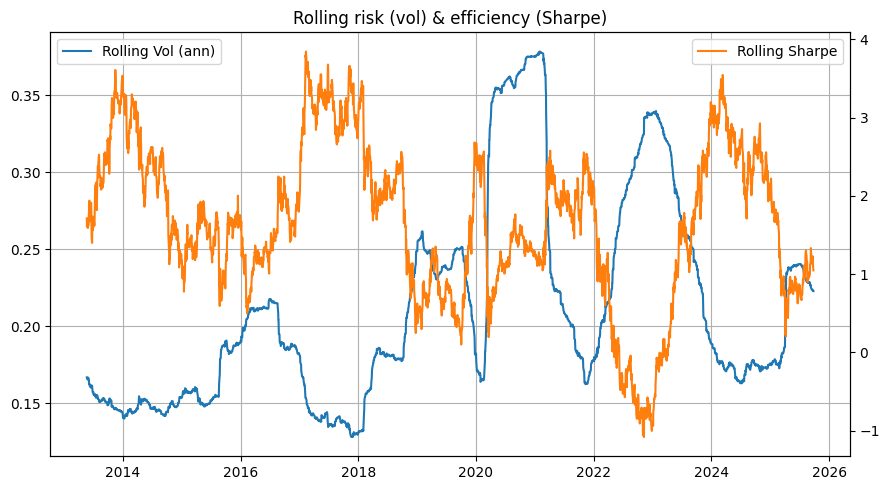

In [7]:
# Equal-Weight Portfolio
n = len(TICKERS)
w_eq = np.ones(n)/n
w_eq = np.minimum(w_eq, MAX_W); w_eq /= w_eq.sum()

mu_vec = (rlog.mean()*252).values
cov_ann = (ret.cov()*252).values

er_eq = float(w_eq @ mu_vec)
vol_eq = float(np.sqrt(w_eq @ cov_ann @ w_eq))
sr_eq  = (er_eq - RF)/vol_eq

print("[PORT EQ] ER={:.2%}  Vol={:.2%}  Sharpe={:.2f}".format(er_eq, vol_eq, sr_eq))

ret_port = ret[TICKERS].dot(w_eq)
wealth   = (1+ret_port).cumprod()
wealth.plot(title="Equal-Weight Portfolio — Cumulative Wealth", grid=True)
plt.tight_layout(); plt.show()

# rolling 1Y vol e rolling Sharpe
roll_vol = ret_port.rolling(252).std()*np.sqrt(252)
roll_mu  = ret_port.rolling(252).mean()*252
roll_sh  = (roll_mu - RF)/roll_vol.replace(0,np.nan)

fig, ax = plt.subplots()
ax.plot(roll_vol.index, roll_vol.values, label="Rolling Vol (ann)")
ax2 = ax.twinx()
ax2.plot(roll_sh.index, roll_sh.values, color="tab:orange", label="Rolling Sharpe")
ax.set_title("Rolling risk (vol) & efficiency (Sharpe)") ; ax.grid(True)
ax.legend(loc="upper left"); ax2.legend(loc="upper right")
plt.tight_layout(); plt.show()

[ALLOC EQ] Leftover before $3,369.54 → after sweep $143.29
        Weight%    Price  Shares   Dollars
Ticker                                    
AMD        6.67   159.46     419  66813.74
NVDA       6.67   178.19     375  66821.25
AMZN       6.67   219.78     304  66813.12
NFLX       6.67  1210.61      55  66583.55
AVGO       6.67   334.53     200  66906.00
GOOGL      6.67   246.54     271  66812.34
MSFT       6.67   511.46     130  66489.80
V          6.67   337.37     198  66799.26
AAPL       6.67   255.46     261  66675.06
LIN        6.67   474.41     141  66891.81
UNH        6.67   344.08     194  66751.52
JPM        6.67   316.06     211  66688.66
ADBE       6.67   360.37     185  66668.45
META       6.67   743.75      89  66193.75
COST       6.67   915.95      72  65948.40


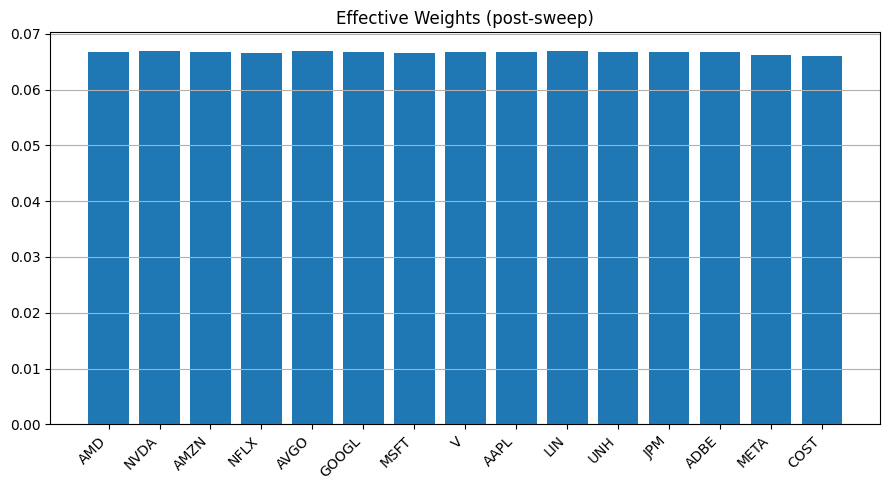

Saved: orders_equal_weight.csv


In [8]:
# Allocation & Sweep (questo spiegato sopra)
def allocation_table(weights, last_px, capital, cap=MAX_W):
    w = np.array(weights, float); w = np.minimum(w, cap); w/=w.sum()
    dollars = w*capital
    shares  = np.floor(dollars/last_px.values).astype(int)
    spent   = shares*last_px.values
    leftover = float(capital - spent.sum())
    df = pd.DataFrame({
        "Weight%": (w*100).round(2),
        "Price":   last_px.values.round(2),
        "Shares":  shares.astype(int),
        "Dollars": spent.round(2)
    }, index=last_px.index).sort_values("Dollars", ascending=False)
    return df, leftover

def sweep_leftover(alloc_df, leftover_cash, capital=CAPITAL, cap=MAX_W):
    df = alloc_df.copy()
    cap_dollars = cap*capital
    changed = True
    while leftover_cash > df["Price"].min() and changed:
        changed = False
        df["Cur$"] = df["Shares"]*df["Price"]
        df["Room$"] = cap_dollars - df["Cur$"]
        cand = df[(df["Room$"] >= df["Price"]) & (df["Price"] <= leftover_cash)].sort_values(["Price","Room$"], ascending=[True, False])
        for t, row in cand.iterrows():
            p = row["Price"]
            if p <= leftover_cash and row["Room$"] >= p:
                df.loc[t,"Shares"] += 1
                df.loc[t,"Dollars"] = df.loc[t,"Shares"]*p
                leftover_cash -= p
                changed = True
                if leftover_cash <= df["Price"].min(): break
    return df.drop(columns=["Cur$","Room$"]), float(leftover_cash)

last_px = prices.iloc[-1]
alloc_eq, left_eq = allocation_table(w_eq, last_px, CAPITAL, MAX_W)
alloc_eq_swept, left_eq2 = sweep_leftover(alloc_eq, left_eq, capital=CAPITAL, cap=MAX_W)

print("[ALLOC EQ] Leftover before ${:,.2f} → after sweep ${:,.2f}".format(left_eq, left_eq2))
print(alloc_eq_swept[["Weight%","Price","Shares","Dollars"]])

# bar pesi effettivi (post-sweep in $)
plt.bar(alloc_eq_swept.index, alloc_eq_swept["Dollars"]/alloc_eq_swept["Dollars"].sum())
plt.xticks(rotation=45, ha="right"); plt.title("Effective Weights (post-sweep)")
plt.grid(True, axis="y"); plt.tight_layout(); plt.show()

# salva ordini
orders = alloc_eq_swept[["Shares"]].rename_axis("Ticker")
orders.to_csv("orders_equal_weight.csv")
print("Saved: orders_equal_weight.csv")

              Return     Vol  Sharpe
Model                               
Equal-Weight  0.2423  0.2191  1.1057
Max-Return    0.2955  0.2510  1.1773
Min-Variance  0.2178  0.1887  1.1541
Max-Sharpe    0.2817  0.2273  1.2394


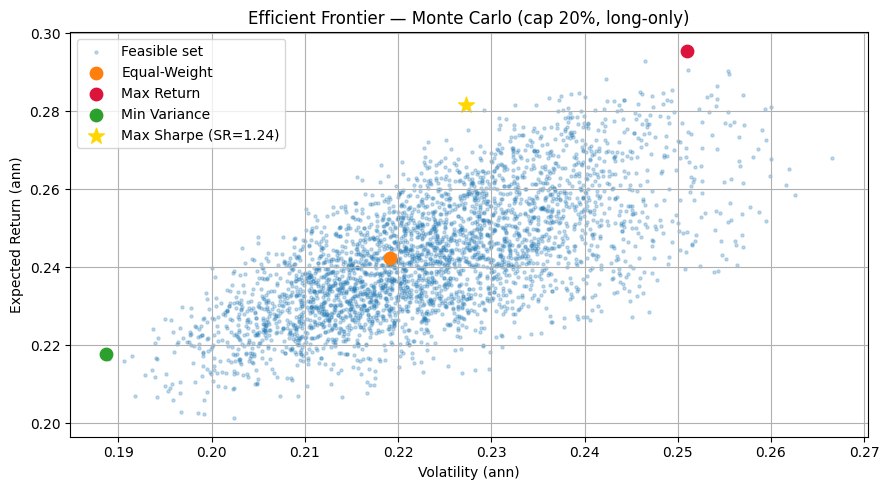


[WEIGHTS] per asset (fractions):
       Equal-Weight  Max-Return  Min-Variance  Max-Sharpe
AAPL         0.0667      0.0417        0.0274      0.0574
MSFT         0.0667      0.0502        0.0157      0.0481
NVDA         0.0667      0.0432        0.0142      0.0162
GOOGL        0.0667      0.0576        0.0368      0.0157
AMZN         0.0667      0.0956        0.0771      0.1231
META         0.0667      0.0383        0.1592      0.0902
AVGO         0.0667      0.0076        0.0831      0.0607
ADBE         0.0667      0.0678        0.0381      0.1006
AMD          0.0667      0.0421        0.1319      0.0192
COST         0.0667      0.0829        0.0558      0.0118
LIN          0.0667      0.0417        0.0727      0.0142
UNH          0.0667      0.1317        0.0255      0.1080
JPM          0.0667      0.2000        0.0337      0.1611
V            0.0667      0.0615        0.1495      0.0820
NFLX         0.0667      0.0383        0.0793      0.0916

[WEIGHTS %] per asset:
       Equal-W

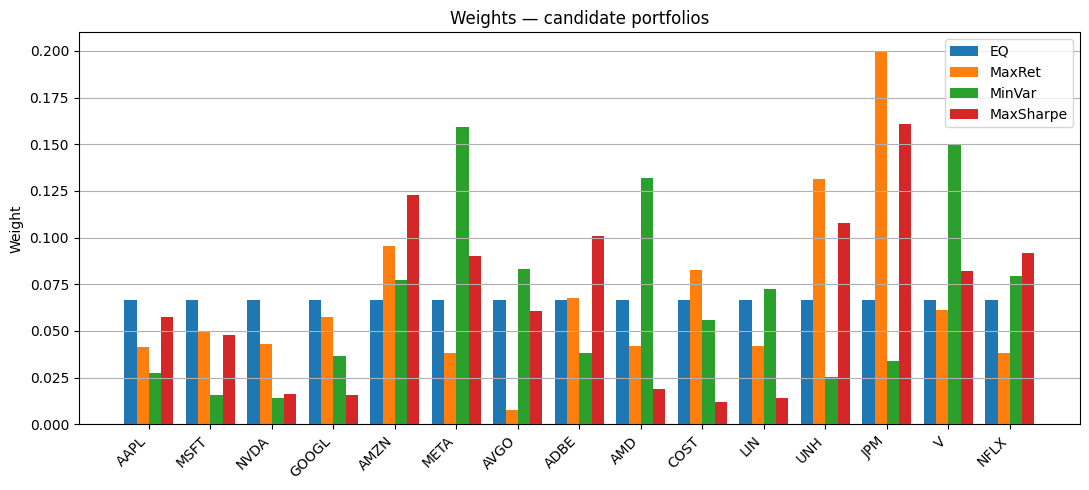


[ALLOC] Equal-Weight — Leftover $3,369.54
        Weight%    Price  Shares   Dollars
Ticker                                    
AMD        6.67   159.46     418  66654.28
NVDA       6.67   178.19     374  66643.06
AMZN       6.67   219.78     303  66593.34
NFLX       6.67  1210.61      55  66583.55
AVGO       6.67   334.53     199  66571.47
GOOGL      6.67   246.54     270  66565.80
MSFT       6.67   511.46     130  66489.80
V          6.67   337.37     197  66461.89
AAPL       6.67   255.46     260  66419.60
LIN        6.67   474.41     140  66417.40
UNH        6.67   344.08     193  66407.44
JPM        6.67   316.06     210  66372.60
ADBE       6.67   360.37     184  66308.08
META       6.67   743.75      89  66193.75
COST       6.67   915.95      72  65948.40

[ALLOC] Max-Return — Leftover $4,147.07
        Weight%    Price  Shares    Dollars
Ticker                                     
NVDA      20.00   178.19    1122  199929.18
NFLX      13.17  1210.61     108  130745.88
AVGO     

In [9]:
# Efficient Frontier
rng = np.random.default_rng(SEED)
n = len(TICKERS); H_MIN = 10  # ENA minimo

def project_feasible(w, cap=MAX_W):
    w = np.clip(w, 0, cap)
    for _ in range(10):
        s = w.sum()
        if abs(s-1.0)<1e-12: break
        if s>1:
            room = w - 0; tr = room.sum()
            if tr>0: w -= (s-1.0)*(room/tr)
        else:
            room = cap - w; tr = room.sum()
            if tr>0: w += (1.0-s)*(room/tr)
        w = np.clip(w, 0, cap)
    return w/w.sum()

def ena(w): return 1.0/np.sum(w**2)
def sample_W(k):
    W=[]
    for _ in range(k):
        w = rng.dirichlet(np.ones(n))
        w = project_feasible(w, MAX_W)
        if ena(w) >= H_MIN: W.append(w)
    return np.array(W) if W else np.array([project_feasible(np.ones(n)/n, MAX_W)])

W = sample_W(20000)
mu_vec = (rlog.mean()*252).values
C = (ret.cov()*252).values
R = W@mu_vec
V = np.sqrt(np.einsum('ij,jk,ik->i', W, C, W))
SR = (R-RF)/np.where(V>0,V,np.nan)

i_ret, i_var, i_shp = np.argmax(R), np.argmin(V), np.nanargmax(SR)
cand = pd.DataFrame({
    "Model":["Equal-Weight","Max-Return","Min-Variance","Max-Sharpe"],
    "Return":[w_eq@mu_vec, R[i_ret], R[i_var], R[i_shp]],
    "Vol":[np.sqrt(w_eq@C@w_eq), V[i_ret], V[i_var], V[i_shp]],
    "Sharpe":[(w_eq@mu_vec-RF)/np.sqrt(w_eq@C@w_eq), SR[i_ret], SR[i_var], SR[i_shp]]
}).set_index("Model").round(4)
print(cand)

plt.scatter(V, R, s=5, alpha=0.25, label="Feasible set")
plt.scatter(np.sqrt(w_eq@C@w_eq), w_eq@mu_vec, s=80, label="Equal-Weight")
plt.scatter(V[i_ret], R[i_ret], s=80, label="Max Return", c="crimson")
plt.scatter(V[i_var], R[i_var], s=80, label="Min Variance", c="tab:green")
plt.scatter(V[i_shp], R[i_shp], s=140, marker="*", label=f"Max Sharpe (SR={SR[i_shp]:.2f})", c="gold")
plt.xlabel("Volatility (ann)"); plt.ylabel("Expected Return (ann)")
plt.title("Efficient Frontier — Monte Carlo (cap 20%, long-only)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


# 1) Pesi per asset (tabella)
weights_df = pd.DataFrame({
    "Equal-Weight": w_eq,
    "Max-Return":   W[i_ret],
    "Min-Variance": W[i_var],
    "Max-Sharpe":   W[i_shp],
}, index=TICKERS)

print("\n[WEIGHTS] per asset (fractions):")
print(weights_df.round(4))

print("\n[WEIGHTS %] per asset:")
print((weights_df*100).round(2))

# 2) Grafico pesi per un colpo d’occhio
plt.figure(figsize=(11,5))
width = 0.2; x = np.arange(len(TICKERS))
plt.bar(x-1.5*width, weights_df["Equal-Weight"], width=width, label="EQ")
plt.bar(x-0.5*width, weights_df["Max-Return"],   width=width, label="MaxRet")
plt.bar(x+0.5*width, weights_df["Min-Variance"], width=width, label="MinVar")
plt.bar(x+1.5*width, weights_df["Max-Sharpe"],   width=width, label="MaxSharpe")
plt.xticks(x, TICKERS, rotation=45, ha="right")
plt.ylabel("Weight"); plt.title("Weights — candidate portfolios")
plt.legend(); plt.grid(True, axis="y"); plt.tight_layout(); plt.show()

# 3) Allocazioni pratiche per valutare altri portfolios
try:
    allocation_table  # noqa
except NameError:
    def allocation_table(weights: np.ndarray, last_px: pd.Series, capital: float, cap=MAX_W):
        w = np.array(weights, float); w = np.minimum(w, cap); w /= w.sum()
        dollars = w*capital
        shares  = np.floor(dollars/last_px.values).astype(int)
        spent   = shares*last_px.values
        leftover = float(capital - spent.sum())
        df = pd.DataFrame({
            "Weight%": (w*100).round(2),
            "Price":   last_px.values.round(2),
            "Shares":  shares.astype(int),
            "Dollars": spent.round(2)
        }, index=last_px.index).sort_values("Dollars", ascending=False)
        return df, leftover

last_px = prices.iloc[-1]

alloc_eq,  left_eq  = allocation_table(w_eq,        last_px, CAPITAL, MAX_W)
alloc_ret, left_ret = allocation_table(W[i_ret],    last_px, CAPITAL, MAX_W)
alloc_mv,  left_mv  = allocation_table(W[i_var],    last_px, CAPITAL, MAX_W)
alloc_sh,  left_sh  = allocation_table(W[i_shp],    last_px, CAPITAL, MAX_W)

print("\n[ALLOC] Equal-Weight — Leftover ${:,.2f}".format(left_eq))
print(alloc_eq[["Weight%","Price","Shares","Dollars"]])

print("\n[ALLOC] Max-Return — Leftover ${:,.2f}".format(left_ret))
print(alloc_ret[["Weight%","Price","Shares","Dollars"]])

print("\n[ALLOC] Min-Variance — Leftover ${:,.2f}".format(left_mv))
print(alloc_mv[["Weight%","Price","Shares","Dollars"]])

print("\n[ALLOC] Max-Sharpe — Leftover ${:,.2f}".format(left_sh))
print(alloc_sh[["Weight%","Price","Shares","Dollars"]])

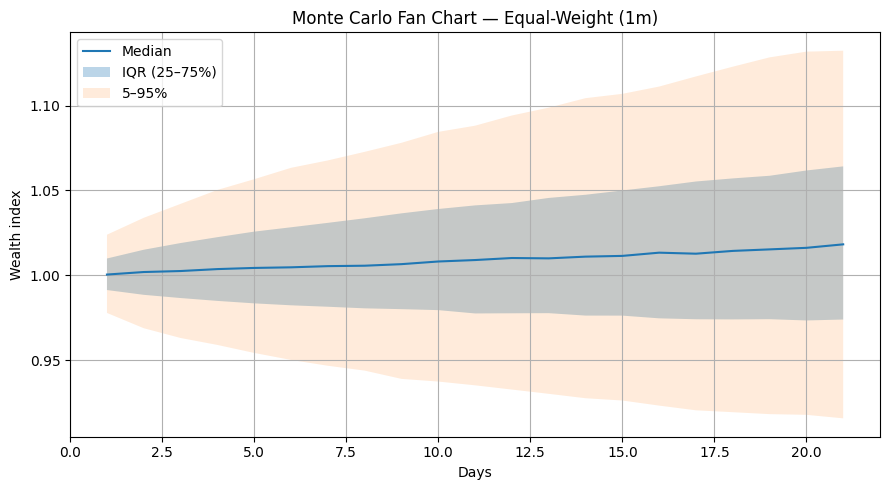

[MC 1m] mean=2.01%  std=6.65%  VaR5%=-8.43%  CVaR5%=-10.83%  P(loss)=39.7%


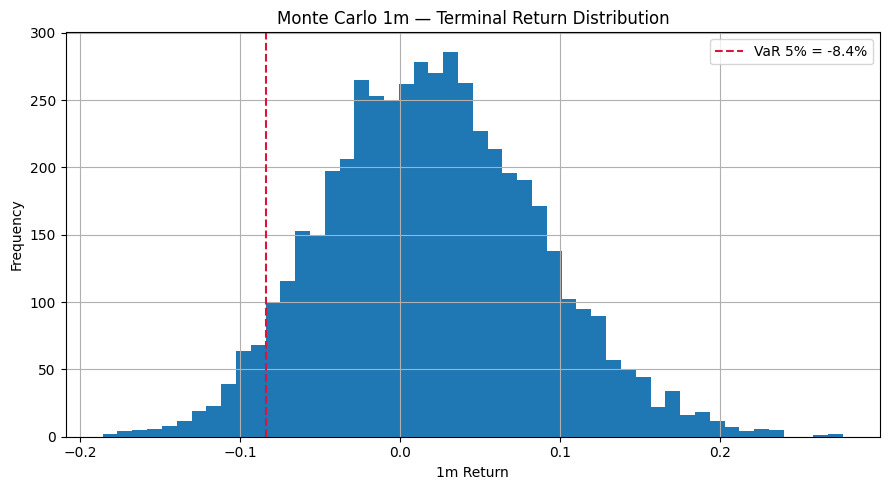

In [10]:
# Monte Carlo Scenarios (1m)

H_DAYS = 21

def mc_portfolio_paths(w, mu_d, cov_d, steps=H_DAYS, sims=N_SIMS, seed=SEED):
    rng = np.random.default_rng(seed)
    L = np.linalg.cholesky(cov_d + 1e-12*np.eye(len(mu_d)))
    port = np.zeros((steps, sims))
    for s in range(steps):
        z = rng.standard_normal((len(mu_d), sims))
        r_day = mu_d.reshape(-1,1) + (L @ z)
        port[s] = (w.reshape(1,-1) @ r_day).ravel()
    wealth = (1 + port).cumprod(axis=0)
    return wealth

# media e cov giornaliere
mu_d  = rlog.mean().values
cov_d = ret.cov().values

paths = mc_portfolio_paths(w_eq, mu_d, cov_d, steps=H_DAYS, sims=N_SIMS)

# quantili
qs = [0.05, 0.25, 0.5, 0.75, 0.95]
qv = np.quantile(paths, qs, axis=1)
x = np.arange(1, paths.shape[0] + 1)
plt.plot(x, qv[2], label="Median")
plt.fill_between(x, qv[1], qv[3], alpha=0.3, label="IQR (25–75%)")
plt.fill_between(x, qv[0], qv[4], alpha=0.15, label="5–95%")
plt.title("Monte Carlo Fan Chart — Equal-Weight (1m)")
plt.xlabel("Days"); plt.ylabel("Wealth index")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# distribuzione rendimenti a 1 mese
final = paths[-1] - 1.0
VaR95  = float(np.quantile(final, 0.05))
CVaR95 = float(final[final <= VaR95].mean())

print("[MC 1m] mean={:.2%}  std={:.2%}  VaR5%={:.2%}  CVaR5%={:.2%}  P(loss)={:.1%}".format(
    float(final.mean()), float(final.std()), VaR95, CVaR95, float((final < 0).mean())
))

plt.hist(final, bins=50)
plt.axvline(VaR95, color="crimson", ls="--", label=f"VaR 5% = {VaR95:.1%}")
plt.title("Monte Carlo 1m — Terminal Return Distribution")
plt.xlabel("1m Return"); plt.ylabel("Frequency")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()